<a href="https://colab.research.google.com/github/somu13/CS61A/blob/master/ResNets_on_Public_Datasets_%5BUnder_Construction%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

The purpose of this notebook is to provide a comparison in performance of deep learning methods that use no data augmentation, traditional data augmentation, and perturbed mesh data augmentation across multiple datasets.

# Helpful Links

https://keras.io/examples/cifar10_resnet/

https://www.juew.org/publication/DocUNet.pdf

https://www.cs.toronto.edu/~kriz/cifar.html

# Packages

In [0]:
from __future__ import print_function

# keras
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10

# scikit learn
import sklearn.model_selection
from sklearn.model_selection import train_test_split

# matplotlib
import matplotlib.pyplot as plt

# numpy
import numpy as np


# Data

The first dataset used in the notebook is the CIFAR-10 dataset. "The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class" (https://www.cs.toronto.edu/~kriz/cifar.html). The 10 classes are airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Although the dataset is pre-split to 50000 training images and 10000 test images, this notebook evaluates models using a variety of train and test set sizes.

The second dataset used in the notebook is the Fashion MNIST dataset. "Fashion-MNIST is a dataset of Zalando’s article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement of the original MNIST dataset for benchmarking machine learning algorithms" (https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/). Although the dataset is pre-split to 60000 training images and 10000 test images, this notebook evaluates models using a variety of train and test set sizes.

The third dataset used in the notebook is the...

In [0]:
# Load data
(X_train_original_cifar, y_train_original_cifar), (X_test_original_cifar, y_test_original_cifar) = cifar10.load_data()

In [13]:
# This cell is a demonstration of how to create a new train/test split and will be incorporated into a function later.

# Concatenate train and test images
X_entire_cifar = np.concatenate((X_train_original_cifar,X_test_original_cifar))
y_entire_cifar = np.concatenate((y_train_original_cifar,y_test_original_cifar))

# Shape of concatenated feature matrix
print(X_entire_cifar.shape)

# Create new train/test split
X_train, X_test, y_train, y_test = train_test_split(X_entire_cifar,y_entire_cifar, train_size = 1250, test_size = 250, random_state = 42)

# Shape of newly split sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(60000, 32, 32, 3)
(1250, 32, 32, 3)
(250, 32, 32, 3)
(1250, 1)
(250, 1)


# Visualize Inputs: CIFAR-10

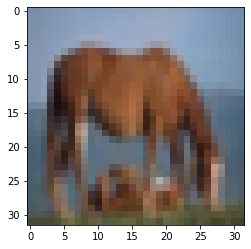

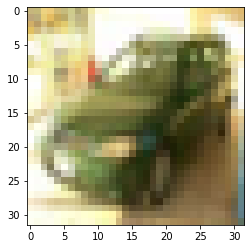

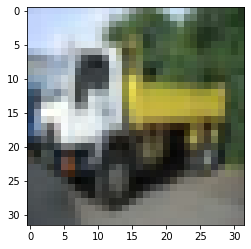

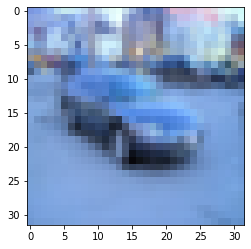

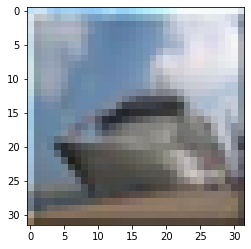

In [14]:
# View first image in training set
plt.imshow(X_train[0])
plt.show()

# View tenthi image in training set
plt.imshow(X_train[9])
plt.show()

# View hundredth image in training set
plt.imshow(X_train[99])
plt.show()

# View first image in test set
plt.imshow(X_test[0])
plt.show()

# View tenth image in test set
plt.imshow(X_test[9])
plt.show()

# ResNet Architecture Implementation

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def concat_and_split(X_train_original, X_test_original, y_train_original, y_test_original, train_size, test_size):
    """Concatenate and Split

    Concatenate pre-split (train/test) datasets and resplit according to new train_size and test_size

    # Arguments
        X_train_original (): 
        X_test_original (): 
        y_train_original (): 
        y_test_original (): 
        train_size (): 
        test_size (): 


    # Returns
        X_train, X_test, y_train, y_test (): 
    """
    # Concatenate train and test images
    X_entire = np.concatenate((X_train_original,X_test_original))
    y_entire = np.concatenate((y_train_original,y_test_original))

    # Create new train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_entire,y_entire, train_size = train_size, test_size = test_size, random_state = 42)

    return X_train, X_test, y_train, y_test

#concat_and_split(X_train_original_cifar, X_test_original_cifar, y_train_original_cifar, y_test_original_cifar, 1250, 250)


# Traditional Data Augmentation

In [0]:
# Defining parameters for traditional data augmentation
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=90,
        # randomly shift images horizontally
        width_shift_range=0.2,
        # randomly shift images vertically
        height_shift_range=0.2,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.2,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.2)


In [70]:
# Need to fix the following 2 cells!
img = X_train[0]
x, y = next(datagen.flow(X_train,y_train, batch_size=9))
x.shape

(9, 32, 32, 3)

In [77]:
# Placeholder to visualize examples of augmented images

img = X_train[0]
#img = img.reshape((1,) + img.shape)
datagen.fit(img)
i=0
for img_batch in datagen.flow(img, batch_size=9):
    for img in img_batch:
        plt.subplot(330 + 1 + i)
        plt.imshow(img)
        i=i+1    
    if i >= batch_size:
        break
        

ValueError: ignored

# Train

In [0]:

def train(X_train_original, X_test_original, y_train_original, y_test_original, num_classes, train_size, test_size, datagen, mesh_augementation, batch_size, epochs, subtract_pixel_mean):
    """Train

    Train dataset on ResNet model with or without traditional or mesh data augmentation

    # Arguments
        X_train_original (): 
        X_test_original (): 
        y_train_original (): 
        y_test_original (): 
        num_classes ():
        train_size (): 
        test_size (): 
        datagen ():
        mesh_augmentation ():
        batch_size ():
        epochs ():
        subtract_pixel_mean ():

    # Returns
        model ():
        
    """
    # Generate sets with test/train split
    x_train, x_test, y_train, y_test = concat_and_split(X_train_original, X_test_original, y_train_original, y_test_original, train_size, test_size)



    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # If subtract pixel mean is enabled
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)

    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)


    # Input image dimensions.
    input_shape = x_train.shape[1:]

    # Input ResNet depth
    depth = 3 * 9 + 2
    model = resnet_v2(input_shape=input_shape, depth=depth)

    # Compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
    
    # Create callbacks for learning rate adjustment
    lr_scheduler = LearningRateScheduler(lr_schedule)
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
    callbacks = [lr_reducer, lr_scheduler]

    # Run training, with or without data augmentation.
    if not datagen:
      print('Not using data augmentation.')
      model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2,
                shuffle=True,
                callbacks=callbacks)
    else:
        datagen.fit(x_train)

        model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        shuffle=True,
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)
    return model

In [22]:
# CIFAR main

# Defining training parameters 
num_images_list = [60000, 45000, 37500, 30000, 22500, 15000, 11250, 7500, 3750, 1500]
train_proportion = 0.83333
X_train_original = X_train_original_cifar
X_test_original = X_test_original_cifar
y_train_original = y_train_original_cifar
y_test_original = y_test_original_cifar
num_classes = 10

# This is a placeholder for after mesh_augmentation function is developed
mesh_augementation = False
batch_size = 32
#epochs = 200
epochs = 1
subtract_pixel_mean = True

# Train model for each image set size
for num_images in num_images_list:
    train_size = int(num_images * train_proportion)
    test_size = num_images-train_size
    model = train(X_train_original, X_test_original, y_train_original, y_test_original, num_classes, train_size, test_size, datagen, mesh_augementation, batch_size, epochs, subtract_pixel_mean)
    #Placeholder for evaluation of model

x_train shape: (49999, 32, 32, 3)
49999 train samples
10001 test samples
y_train shape: (49999, 1)
Learning rate:  0.001
Epoch 1/1
Learning rate:  0.001
   4/1563 [..............................] - ETA: 58:49 - loss: 2.9611 - accuracy: 0.1328  

KeyboardInterrupt: ignored